# Objective
* 20190822:
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * We use triple exponential smoothing to predict

In [1]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import time

from collections import defaultdict
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H = 21
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set

# alpha - smoothing coeff
alphaMax = 0.99
alphaMin = 0.01
alphaStep = 0.01

# beta - trend coeff
betaMax = 0.99
betaMin = 0.01
betaStep = 0.01

# gamma - seasonality coeff
gammaMax = 0.9
gammaMin = 0.1
gammaStep = 0.1   

L = 252                        # seasonality period

# for plot display
daysBackward = 30
daysForward = 60

i_list = range(1008, 1008+84*5+42+1, 42) # we want to do a forecast on these days

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [2]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [19]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def initial_trend(series, L):
    """
    Initial trend, b_1 = ( (y_L+1 - y_1)/L + (y_L+2 - y_2)/L + ... + (y_L+L - y_L)/L ) / L
    """
    sum = 0.0
    for i in range(L):
        sum += float(series[i+L] - series[i]) / L
        
    return sum / L

def initial_seasonal_components(series, L):
    """
    Initial seasonal index, 
    I_t = ( y_t-A_1 + y_{t+L}-A_2 + ... + y_{t+(P-1)L}-A_P ) / P, 
    t = 1, 2, ..., L
    Here P is the number of seasons we have in the series.
    For example, for sales data, we have 2018 Q1, 2018 Q2, 2018 Q3, 2018 Q4 data. These 4 points represent 1 season.
    A_1 is the mean of the values in the first season, and so on.
    Returns the seasonal components of length L in a list
    """
    seasonals = []
    season_averages = []
    n_seasons = int(len(series)/L)
    
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[L*j:L*j+L])/float(L))
    
    # compute initial values
    for i in range(L):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[L*j+i]-season_averages[j]
        seasonals.append(sum_of_vals_over_avg/n_seasons)
        
    return seasonals

def triple_exponential_smoothing(series, L, H, alpha=0.3, beta=0.3, gamma=0.3, return_all=False):
    """
    Overall smoothing:  S_t = alpha*(y_t - I_{t-L}) + (1-alpha)(S_{t-1} + b_{t-1}})
    Trend smoothing:    b_t = beta*(S_t - S_{t-1}) + (1-beta)*b_{t-1}
    Seasonal smoothing: I_t = gamma*(y_t - S_t) + (1-gamma)*I_{t-L}
    Forecast:           F_{t+m} = S_t + m*b_t + I_{t-L+m}, m >= 1
    Note here m has to be < len(series)
    result[len(series)] is the estimate of series[len(series)]
    The length of result is len(series) + H, where H >= 1
    """
    result = [0, series[0]]
    smooth = series[0]
    trend = initial_trend(series, L)
    seasonals = initial_seasonal_components(series, L)
    seasonals.append(seasonals[0]) # To make the seasonals elements align with series elements
    for n in range(1, len(series)+H-1):
        if n >= len(series): # we are forecasting
            m = n - len(series) + 2
            result.append(smooth + m*trend + seasonals[n+1])
        else:
            val = series[n]
            last_smooth, smooth = smooth, alpha*(val-seasonals[n]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals.append(gamma*(val-smooth) + (1-gamma)*seasonals[n])
            result.append(smooth + trend + seasonals[n+1])
            # e.g. result[2] uses series[1], seasonals[1], and seasonals[2]
            # ie. result[2] is the estimate of series[2]
            # e.g. result[len(series)] uses series[len(series)-1], seasonals[len(series)-1], and seasonals[len(series)] 
            # ie. result[len(series)] is the estimate of series[len(series)]
            
    if return_all == True:
        return result, seasonals
    else:
        return result[len(series):len(series)+H], seasonals

def get_error_metrics(series, train_size, L, H, alpha, beta, gamma):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
        alpha      : smoothing coeff
        beta       : trend coeff
        gamma      : seasonality coeff
    Outputs
        mean of rmse, mean of mape, mean of mae
    """
    # Predict using single exponential smoothing, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    for i in range(train_size, len(series)-H+1, int(H/2)):
        preds_list, seasonals = triple_exponential_smoothing(series[i-train_size:i], L, H, alpha, beta, gamma)
        
        rmse.append(get_rmse(series[i:i+H], preds_list))
        mape.append(get_mape(series[i:i+H], preds_list))
        mae.append(get_mae(series[i:i+H], preds_list))
        preds_dict[i] = preds_list
    
    return np.mean(rmse), np.mean(mape), np.mean(mae), preds_dict    
    
def hyperparam_tune_alpha_beta_gamma(series, train_size, L, H):
    """
    Given a series, tune hyperparameter alpha, fit and predict
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
    Outputs
        optimum hyperparameters, error metrics dataframe
    """
    err_dict = defaultdict(list)
    alpha = alphaMin
    while alpha <= alphaMax:
        beta = betaMin
        while beta <= betaMax:
            gamma = gammaMin
            while gamma <= gammaMax:
                rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(series, train_size, L, H, alpha, beta, gamma)
        
                # Append alpha and beta
                err_dict['alpha'].append(alpha)
                err_dict['beta'].append(beta)
                err_dict['gamma'].append(gamma)
    
                # Compute error metrics
                err_dict['rmse'].append(rmse_mean)
                err_dict['mape'].append(mape_mean)
                err_dict['mae'].append(mae_mean)
                
                # Increase gamma by one step
                gamma = gamma + gammaStep
            
            # Increase beta by one step
            beta = beta + betaStep
        
        # Increase alpha by one step
        alpha = alpha + alphaStep
    
    # Convert to dataframe
    err_df = pd.DataFrame(err_dict)
    
    # Get min RMSE
    rmse_min = err_df['rmse'].min()
    
    return err_df[err_df['rmse'] == rmse_min]['alpha'].values[0], \
           err_df[err_df['rmse'] == rmse_min]['beta'].values[0], \
           err_df[err_df['rmse'] == rmse_min]['gamma'].values[0], \
           err_df

# Load data

In [4]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [5]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

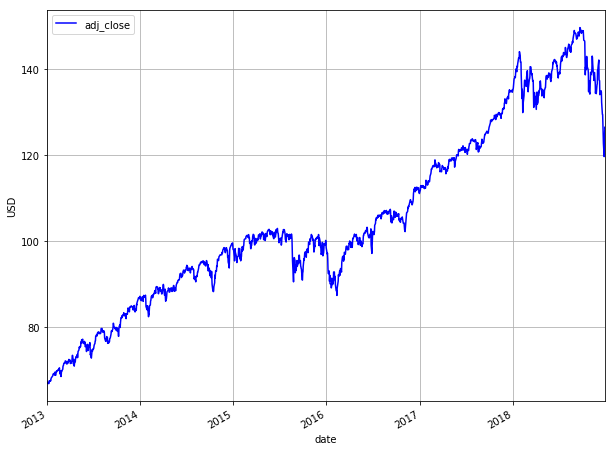

In [6]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict for a specific H (forecast horizon) and a specific date, plot original series too

In [7]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [8]:
# Predict
preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, 0.3, 0.55, 0.6, True)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 13.453658
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 11.429246
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 12.902018


(734871.0, 736353.0)

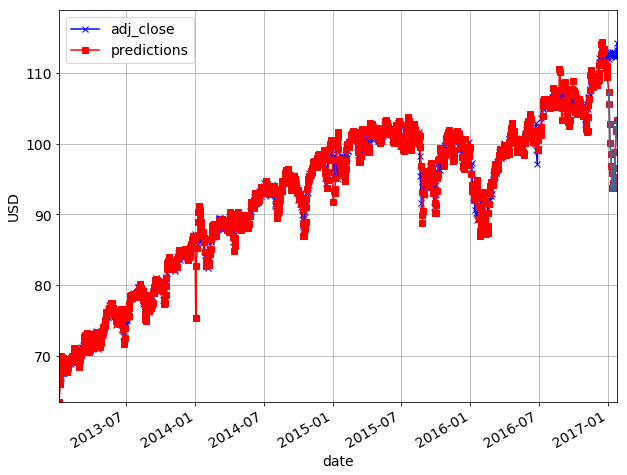

In [9]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i-train_val_size:i+H], preds_list, marker='s', color='r')
ax.plot(df['date'][i:i+H], preds_list[train_val_size:train_val_size+H], marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list[1:]), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list[1:]), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i-train_val_size+1], df['date'][i]+timedelta(days=H)])
# ax.set_xlim(['2016-06-01', '2017-02-01'])
# ax.set_ylim([60, 85])

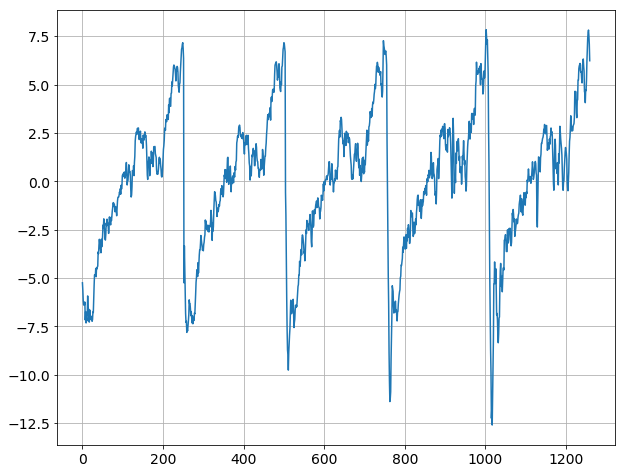

In [10]:
# Plot the seasonals
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

plt.plot(seasonals)
plt.grid()
# plt.xlim([0, 252])

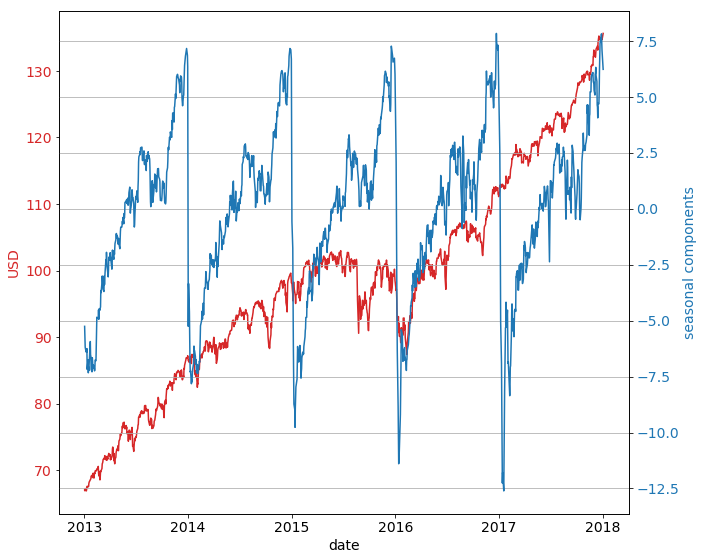

In [11]:
# Plot the seasonals with actual values on dual axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('USD', color=color)
ax1.plot(df['date'][:len(seasonals)], df['adj_close'][:len(seasonals)], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('seasonal components', color=color)  # we already handled the x-label with ax1
ax2.plot(df['date'][:len(seasonals)], seasonals, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# ax1.set_xlim(['2016-01-01', '2016-12-31'])
plt.grid()
plt.show()

# Predict for a specific H (forecast horizon) and a specific date

In [12]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [20]:
# Predict
preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, 0.3, 0.55, 0.6)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

len(series) = 1008
n_seasons = 4
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 13.453658
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 11.429246
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 12.902018


(736302.0, 736392.0)

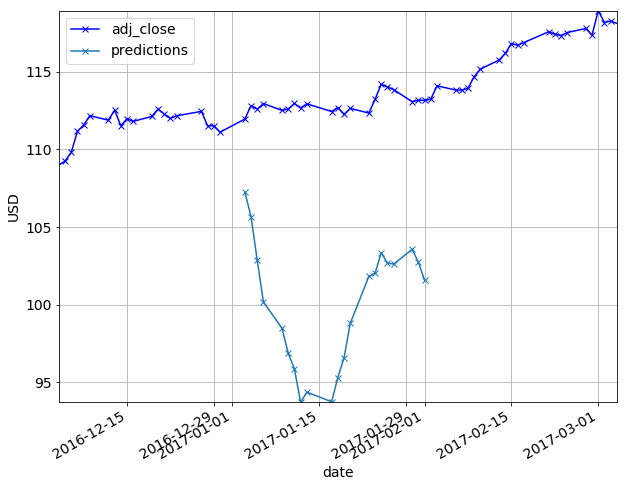

In [14]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i]-timedelta(days=daysBackward), df['date'][i]+timedelta(days=daysForward)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - alpha, beta, gamma

In [15]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [22]:
# Get optimum hyperparams
alpha_opt, beta_opt, gamma_opt, err_df = hyperparam_tune_alpha_beta_gamma(df['adj_close'][i-train_val_size:i].values, train_size, L, H)
print("alpha_opt = " + str(alpha_opt))
print("beta_opt = " + str(beta_opt))
print("gamma_opt = " + str(gamma_opt))
print("rmse opt = " + str(err_df[(err_df['alpha']==alpha_opt) & (err_df['beta']==beta_opt)]['rmse'].values[0]))
err_df

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(series) = 756
n_seasons = 3
len(seri

KeyboardInterrupt: 

In [378]:
# Predict
preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, alpha_opt, beta_opt, gamma_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 7.508197
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 6.560052
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 7.409529


(736302.0, 736392.0)

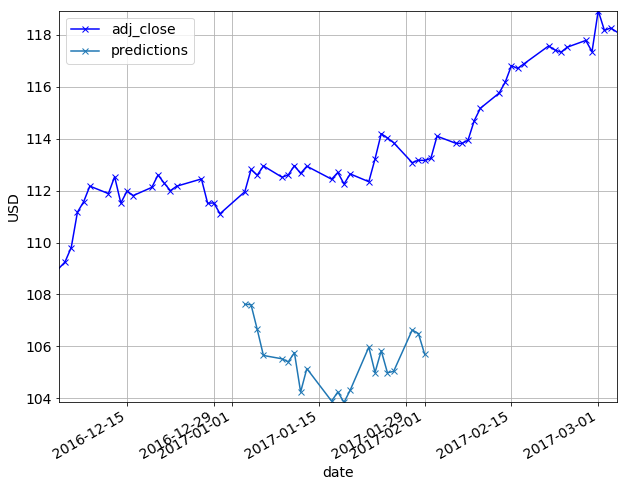

In [379]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i]-timedelta(days=daysBackward), df['date'][i]+timedelta(days=daysForward)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [380]:
print("alpha_opt = " + str(alpha_opt))
print("beta_opt = " + str(beta_opt))
print("gamma_opt = " + str(gamma_opt))

alpha_opt = 0.01
beta_opt = 0.01
gamma_opt = 0.6


In [381]:
# Predict and compute error metrics also
preds_dict = {}
results_final_no_tune = defaultdict(list)
for i in i_list:
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
        
    preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, alpha_opt, beta_opt, gamma_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    results_final_no_tune['rmse'].append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['mape'].append(get_mape(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['mae'].append(get_mae(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['day'].append(df.iloc[i]['date'])
    
results_final_no_tune = pd.DataFrame(results_final_no_tune)

print("Altogether we made %d forecasts, each of length %d days" % (len(results_final_no_tune), H))

Predicting on day 1008, date 2017-01-03 00:00:00
Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


In [382]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, results_final_no_tune['rmse'].mean()))
print("For forecast horizon %d, the mean MAPE is %f" % (H, results_final_no_tune['mape'].mean()))
print("For forecast horizon %d, the mean MAE is %f" % (H, results_final_no_tune['mae'].mean()))

# Put results into pickle
pickle.dump(results_final_no_tune['rmse'].mean(), 
            open("./out/rmse_no_tune_" + str(train_size) + "_" + str(val_size) + ".pickle", "wb"))

For forecast horizon 21, the mean RMSE is 4.277547
For forecast horizon 21, the mean MAPE is 3.070812
For forecast horizon 21, the mean MAE is 4.006715


In [383]:
results_final_no_tune['alpha_opt'] = [alpha_opt]*len(i_list)
results_final_no_tune['beta_opt'] = [beta_opt]*len(i_list)
results_final_no_tune['gamma_opt'] = [gamma_opt]*len(i_list)
results_final_no_tune

,rmse,mape,mae,day,alpha_opt,beta_opt,gamma_opt
0,7.508197,6.560052,7.409529,2017-01-03,0.01,0.01,0.6
1,1.727703,1.373494,1.608573,2017-03-06,0.01,0.01,0.6
2,2.624739,2.080945,2.482449,2017-05-04,0.01,0.01,0.6
3,3.422778,2.750051,3.373258,2017-07-05,0.01,0.01,0.6
4,1.688533,1.205826,1.508049,2017-09-01,0.01,0.01,0.6
5,2.177455,1.322216,1.720662,2017-11-01,0.01,0.01,0.6
6,8.665690,5.912164,8.337260,2018-01-03,0.01,0.01,0.6
7,4.932126,2.869467,3.833605,2018-03-06,0.01,0.01,0.6
8,3.706116,2.559201,3.526532,2018-05-04,0.01,0.01,0.6
9,2.069484,1.351676,1.934408,2018-07-05,0.01,0.01,0.6


(736302.0, 737059.0)

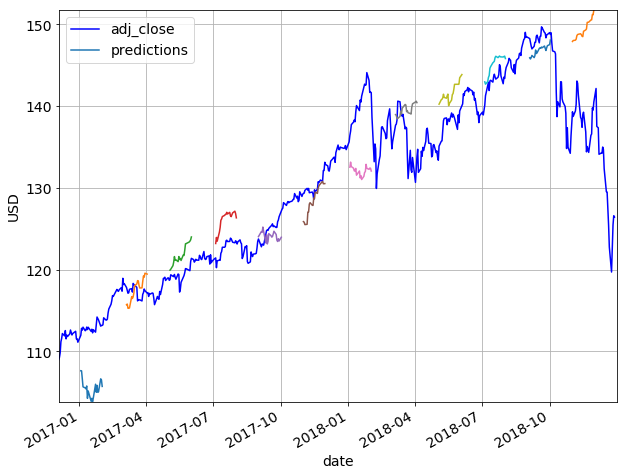

In [384]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
firstDay = df['date'][min(i_list)]-timedelta(days=daysBackward)
lastDay = df['date'][max(i_list)]+timedelta(days=daysForward)
ax.set_ylim([min(min(min(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].min()
                ), 
             max(max(max(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].max()
                )
            ])
ax.set_xlim([firstDay, lastDay]) 

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [385]:
# Predict and compute error metrics also
preds_dict = {}
results_final = defaultdict(list)
tic = time.time()
for i in i_list:
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
    
    # Get optimum hyperparams
    alpha_opt, beta_opt, gamma_opt, err_df = hyperparam_tune_alpha_beta_gamma(df['adj_close'][i-train_val_size:i].values, train_size, L, H)
        
    preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, alpha_opt, beta_opt, gamma_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    results_final['rmse'].append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    results_final['mape'].append(get_mape(df[i:i+H]['adj_close'], preds_list))
    results_final['mae'].append(get_mae(df[i:i+H]['adj_close'], preds_list))
    results_final['alpha_opt'].append(alpha_opt)
    results_final['beta_opt'].append(beta_opt)
    results_final['gamma_opt'].append(gamma_opt)
    results_final['day'].append(df.iloc[i]['date'])
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

results_final = pd.DataFrame(results_final)

print("Altogether we made %d forecasts, each of length %d days" % (len(results_final), H))

Predicting on day 1008, date 2017-01-03 00:00:00
Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Time taken = 0.09153225421905517 mins
Altogether we made 12 forecasts, each of length 21 days


In [386]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, results_final['rmse'].mean()))
print("For forecast horizon %d, the mean MAPE is %f" % (H, results_final['mape'].mean()))
print("For forecast horizon %d, the mean MAE is %f" % (H, results_final['mae'].mean()))

# Put results into pickle
pickle.dump(results_final['rmse'].mean(), 
            open("./out/rmse_w_tune_" + str(train_size) + "_" + str(val_size) + ".pickle", "wb")
           )

For forecast horizon 21, the mean RMSE is 4.277547
For forecast horizon 21, the mean MAPE is 3.070812
For forecast horizon 21, the mean MAE is 4.006715


In [395]:
# results
results_final

In [396]:
# Put results into pickle
pickle.dump(results_final, 
            open("./out/results_final_" + str(train_size) + "_" + str(val_size) + ".pickle", "wb")
           )

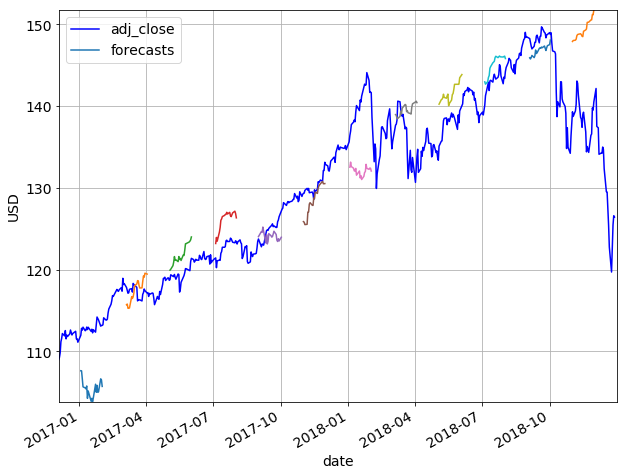

In [388]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
firstDay = df['date'][min(i_list)]-timedelta(days=daysBackward)
lastDay = df['date'][max(i_list)]+timedelta(days=daysForward)
ax.set_ylim([min(min(min(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].min()
                ), 
             max(max(max(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].max()
                )
            ])
ax.set_xlim([firstDay, lastDay]) 
ax.legend(['adj_close', 'forecasts'])

# Save figure:
fig = ax.get_figure()
fig.savefig("./out/forecasts_" + str(train_size) + "_" + str(val_size) + ".png", bbox_inches='tight')

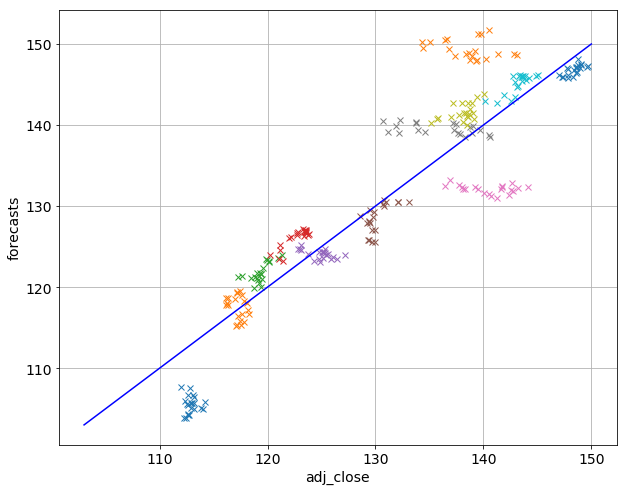

In [398]:
# Plot scatter plot of actual values vs. predictions
for key in preds_dict:
    plt.plot(df['adj_close'][key:key+H], preds_dict[key], 'x')
    
plt.plot(range(int(min(min(preds_dict.values()))), int(max(max(preds_dict.values()))), 1), 
         range(int(min(min(preds_dict.values()))), int(max(max(preds_dict.values()))), 1), 'b-')
    
plt.xlabel('adj_close')
plt.ylabel('forecasts')
plt.grid()

# Save figure:
plt.savefig("./out/forecasts_vs_actuals_" + str(train_size) + "_" + str(val_size) + ".png", bbox_inches='tight')

# Findings

In [399]:
rmse_no_tune = pickle.load(open( "./out/rmse_no_tune_" + str(756) + "_" + str(252) + ".pickle", "rb"))
rmse_no_tune

6.3890469422233025

In [400]:
rmse_w_tune = pickle.load(open( "./out/rmse_w_tune_" + str(756) + "_" + str(252) + ".pickle", "rb"))
rmse_w_tune

3.9138689765554098

In [401]:
results_final = pickle.load(open( "./out/results_final_" + str(756) + "_" + str(252) + ".pickle", "rb"))
results_final

,rmse,mape,mae,alpha_opt,beta_opt,gamma_opt,day
0,4.168968,3.174450,3.587009,0.01,0.82,0.1,2017-01-03
1,2.383543,1.739907,2.043018,0.01,0.81,0.1,2017-03-06
2,3.475685,2.194834,2.620130,0.01,0.81,0.1,2017-05-04
3,1.902753,1.222397,1.495933,0.01,0.82,0.1,2017-07-05
4,3.213167,2.256495,2.830737,0.01,0.03,0.3,2017-09-01
5,1.205045,0.770045,1.001286,0.02,0.01,0.5,2017-11-01
6,7.105624,4.704703,6.644366,0.02,0.01,0.5,2018-01-03
7,5.014713,2.926263,3.909924,0.01,0.01,0.4,2018-03-06
8,3.418152,2.362454,3.254915,0.01,0.01,0.4,2018-05-04
9,1.378541,0.856429,1.228824,0.03,0.01,0.7,2018-07-05


In [392]:
train_size

756

In [393]:
val_size

252

In [394]:
# Collect the results from various experiments
# # alpha - smoothing coeff
# alphaMax = 0.99
# alphaMin = 0.01
# alphaStep = 0.01

# # beta - trend coeff
# betaMax = 0.99
# betaMin = 0.01
# betaStep = 0.01

# # gamma - seasonality coeff
# gammaMax = 0.9
# gammaMin = 0.1
# gammaStep = 0.1   

# L = 252                        # seasonality period

results_dict = pd.DataFrame({'train_size': [756, 756, 756, 756],
                             'val_size': [21, 63, 126, 252],
                             'before_tune_rmse': [11.4343, 10.7199, 6.2241, 6.3890],
                             'after_tune_rmse': [4.5537, 5.0689, 4.5988, 3.9139]})
results_dict

,train_size,val_size,before_tune_rmse,after_tune_rmse
0,756,21,11.4343,4.5537
1,756,63,10.7199,5.0689
2,756,126,6.2241,4.5988
3,756,252,6.3890,3.9139
